<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project: Web APIs & NLP

## Goals
This project is to collect posts from two subreddits ('AskWomen' and 'AskMen') from www.reddit.com, and train two models (random forest and logistic regressin) to classify which subreddit a given post came from.

We will:
- collect posts Using Pushshift's API
- NLP with regex tokenizer, lemmatizer,  stemmer and tfidf-vectorizer
- train two models (random forest and logistic regressin) 
- analyse contribution of top 20 important features



## Dataset and Data Directory

- One dataset is collected from https://www.reddit.com/r/AskWomen/, which contains 2000 posts with 70 columns 

- The other dataset is collected from https://www.reddit.com/r/Askmen/, which contains 2000 posts with 70 columns 

- Some important features are listed as below 


|Feature|Type|Description|
|---|---|---|
|**subreddit**|*String*|subsidiary threads or categories within the Reddit website. | 
|**author**|*String*|The author of a post fetched from the subreddit|
|**title**|*String*|The title of a post fetched from the subreddit|
|**selftext**|*String*|The body text of a post fetched from the subreddit|



## Metrics
- To use `ROC AUC` to compare model performance
    - The closer to 1, the better `ROC AUC` is
    - perc_diff must be less than 5%
- To compare `Accuracy score` too. Since our data is balance and both positive and negative results are of same importance to us, `accuracy score` is another good metric which is understandable and intuitive even to a non-technical person
    - The closer to 1, the better 'Accuracy' is
    - perc_diff must be less than 5%


In [1]:
# install wordcloud if neccessary

In [2]:
pip install wordcloud  

Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [3]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay,accuracy_score, RocCurveDisplay, roc_auc_score
#from sklearn.naive_bayes import MultinomialNB,ComplementNB,GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier,AdaBoostClassifier
#from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import partial_dependence,PartialDependenceDisplay
from sklearn.feature_extraction import _stop_words

import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords



import pickle
import requests
import time

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 


# define some functions

In [4]:
#The function will act as a tokenizer to pass to CountVectorizer, TfidfVectorizer
#The function will:
#      1.  convert the input text to lower case
#      2.  tokenize the input text based on regex(r'(?u)\b\w\w+\b')
#      3. return the tokens
def regex_tokenize(text):
    regex_tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
    tokens = regex_tokenizer.tokenize(text.lower())
    return tokens



In [5]:
#The function will act as a tokenizer to pass to CountVectorizer, TfidfVectorizer
#The function will:
#      1.  call regex_tokenize() to tokenize the input text 
#      2.  stem and return the tokens
def stem_tokenize(text):
    #call regex_tokenize() to tokenize the input text 
    regex_tokens = regex_tokenize(text)

    #get the stopwords, we will not stem the tokens if they belong to stopwords
    stopwords_ = _stop_words.ENGLISH_STOP_WORDS
    
    #instantiate stemmer
    stemmer = PorterStemmer()
    
    #stem tokens, but we will not stem the tokens if they belong to stopwords
    stem_tokens = []
    for item in regex_tokens:
        if item not in stopwords_:
            stem_tokens.append(stemmer.stem(item))
        else:
            stem_tokens.append(item)
    return stem_tokens

In [6]:
#The function will act as a tokenizer to pass to CountVectorizer, TfidfVectorizer
#The function will:
#      1.  call regex_tokenize() to tokenize the input text 
#      2.  Lemmatize and return the tokens

def lem_tokenize(text):
     #call regex_tokenize() to tokenize the input text 
    regex_tokens = regex_tokenize(text)
    
    #get the stopwords, we will not stem the tokens if they belong to stopwords
    stopwords_ = _stop_words.ENGLISH_STOP_WORDS
    
    #instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    #Lemmatize tokens, but we will not lemmatize the tokens if they belong to stopwords
    lem_tokens = []
    for item in regex_tokens:
        if item not in stopwords_:
            lem_tokens.append(lemmatizer.lemmatize(item))
        else:
            lem_tokens.append(item)
    return lem_tokens

In [7]:
#based on the input parameters, this funtion will:
# 1. count-vectorize the input corpus
# 2. return the n_gram words 
def get_ngram(corpus,
              tokenizer_ = None,
              n_gram=1,  
             ):
    
    #count vectorize the input corpus
    vec = CountVectorizer(ngram_range=(n_gram, n_gram), 
                          stop_words='english',
                          tokenizer = tokenizer_
                         ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    
    #sorted bag_of_words by words_frequency
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq

In [8]:
#based on the input parameters, this funtion will:
# 1. get n_gram words_freq list
# 2. plot and return the top frequent n_gram words 
def plot_top_ngram(corpus,
                  tokenizer_ = None,
                  n_gram=1,  
                  top_n=10   # how many words to return
                 ):
    
    #get n_gram words_freq list
    words_freq = get_ngram(corpus,tokenizer_,n_gram)
    
    #plot and return the top n_gram words 
    x,y=map(list,zip(*(words_freq[:top_n])))
    # Set figure size.
    plt.figure(figsize = (12,8))
    ax = sns.barplot(x=y,y=x,palette="Dark2")
    ax.bar_label(ax.containers[0])
    #plt.bar(y,x)
    plt.yticks(fontsize=14, rotation=0)
    plt.title(f"Most frequent {n_gram}_gram words")
    plt.show()
    return words_freq[:top_n]

In [9]:
#based on the input parameters, this funtion will:
# 1. get n_gram words_freq list
# 2. plot wordcloud 
def plot_wordcloud(corpus,
                   tokenizer_ = None,
                   n_gram=1,  
                   bg_color="black"):
    
    #get n_gram words_freq list and convert it into dictionary
    words_freq_dict = dict(get_ngram(corpus,tokenizer_,n_gram))
    
    
    #instantiate wordcloud
    wordcloud = WordCloud( width = 800, height = 1200,
                           background_color=bg_color,
                           stopwords=set(STOPWORDS),
                          # min_word_length =3,
                           max_words=200,
                           #max_font_size=30,
                           min_font_size = 10,
                           #scale=4,
                           random_state=1
                         )
    
    #plot the wordcloud
    wordcloud=wordcloud.generate_from_frequencies(words_freq_dict)
    fig = plt.figure(1, figsize=(8, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

In [97]:
#The function will:
# 1. run the input GridSearchCV
# 2. compute and compare the roc_auc_score, accuracy score for training data and testing data
# 3. get and print the confusion matrix
# 4. plot the confusion matrix and ROC curve

def run_model(gs, X_train, y_train, X_test, y_test ):
    
    # run the input GridSearchCV
    gs.fit(X_train, y_train)
    
    print("best_params: ")
   # print(gs.best_params_)
    for (item, value) in gs.best_params_.items():
        print('   ',item, ' : ', value)
    
    #compute and compare the auc_score for training data and testing data
    train_auc_score = gs.score(X_train, y_train)
    test_auc_score = gs.score(X_test, y_test)
    auc_perc_diff = np.abs(test_auc_score/train_auc_score*100-100)
    
    print(f'\nroc_auc_score on training set: {train_auc_score:.3f}')
    print(f'roc_auc_score on testing set: {test_auc_score:.3f}')
    print(f'perc_diff: {auc_perc_diff:.1f} %\n')
    
    # Get predictions
    y_train_preds = gs.predict(X_train) 
    y_test_preds = gs.predict(X_test)
    
    #calculate the accuracy_score
    train_accur_score =  accuracy_score(y_train, y_train_preds)
    test_accur_score = accuracy_score(y_test, y_test_preds)
    accur_perc_diff = np.abs(test_accur_score/train_accur_score*100-100)
    print(f'\naccuracy_score on training set: {train_accur_score:.3f}')
    print(f'accuracy_score on testing set: {test_accur_score:.3f}')
    print(f'perc_diff: {accur_perc_diff:.1f} %\n')
    
    
    
    # Save confusion matrix values
    print("confusion matrix: ")
    cm = confusion_matrix(y_test, y_test_preds)
    cm_df = pd.DataFrame(cm, columns=['pred AskWomen', 'pred AskMen'], 
                         index=['actual AskWomen', 'actual AskMen'])
    print(cm_df.head())
                    
        
    print("\nplot confusion matrix and ROC curve")
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=[10,5])
    
    # View confusion matrix
    ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, ax=ax1)
    ax1.set_title("confusion matrix")
    
    #plot ROC curve
    RocCurveDisplay.from_estimator(gs, X_test, y_test,ax=ax2) 
    plt.show()


# Load Data

In [11]:
pick_dict = pickle.load(open('../datasets/data.pkl', 'rb'))

In [12]:
#load data for subreddit 'AskWomen'
df_askwomen = pick_dict['df_askwomen']
print(df_askwomen.shape)
df_askwomen.head()

(1999, 70)


,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,removed_by_category,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,author_flair_template_id,author_flair_text_color,author_flair_background_color,banned_by,author_cakeday,post_hint,preview,call_to_action,category
0,[],False,naughtygeekyredditor,None,[],None,text,t2_6ch7kb03,False,False,False,[],False,False,1658491375,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58vxv,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,True,all_ads,/r/AskWomen/comments/w58vxv/how_often_do_you_m...,False,6,automod_filtered,1658491386,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822025,public,top,nsfw,How often do you masturbate?,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,promo_adult_nsfw,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,kia-audi-spider-legs,None,[],None,text,t2_kjkrn8oa,False,False,False,[],False,False,1658491121,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58shp,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskWomen/comments/w58shp/how_would_you_hear...,False,6,moderator,1658491132,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822016,public,top,self,How would you hear “No one could ever be as at...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,kia-audi-spider-legs,None,[],None,text,t2_kjkrn8oa,False,False,False,[],False,False,1658491016,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58rbp,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskWomen/comments/w58rbp/no_one_could_ever_...,False,6,moderator,1658491027,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822012,public,top,self,“No one could ever be as attracted to you as I...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,tsbxred,female,[],♀,text,t2_om297,False,False,False,[],False,False,1658490938,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58qi4,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskWomen/comments/w58qi4/what_is_your_exper...,False,6,automod_filtered,1658490949,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822007,public,top,self,What is your experience of staying with a miso...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,8106c61a-c8aa-11e1-a771-12313b0ce1e2,dark,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Spiritual-Ad8437,None,[],None,text,t2_7xt6wpkw,False,False,False,[],False,False,1658490589,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58mnf,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskWomen/comments/w58mnf/why_is_it_more_soc...,False,6,automod_filtered,1658490600,1,[removed],True,False,False,AskWomen,t5_2rxrw,3821993,public,top,self,Why is it more socially acceptable when a woma...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_askwomen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 70 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  1999 non-null   object 
 1   allow_live_comments            1999 non-null   bool   
 2   author                         1999 non-null   object 
 3   author_flair_css_class         42 non-null     object 
 4   author_flair_richtext          1992 non-null   object 
 5   author_flair_text              42 non-null     object 
 6   author_flair_type              1992 non-null   object 
 7   author_fullname                1992 non-null   object 
 8   author_is_blocked              1999 non-null   bool   
 9   author_patreon_flair           1992 non-null   object 
 10  author_premium                 1992 non-null   object 
 11  awarders                       1999 non-null   object 
 12  can_mod_post                   1999 non-null   b

In [14]:
df_askmen = pick_dict['df_askmen']
print(df_askmen.shape)
df_askmen.head()

(2000, 67)


,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,removed_by_category,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,author_flair_background_color,author_flair_template_id,author_flair_text_color,banned_by,post_hint,preview,author_cakeday
0,[],False,capuccinohedgie,None,[],None,text,t2_8q465stc,False,False,False,[],False,False,1658491492,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58xe...,{},w58xer,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskMen/comments/w58xer/is_wearing_a_wig_a_t...,False,6,moderator,1658491502,1,[removed],True,False,False,AskMen,t5_2s30g,4000940,public,self,Is wearing a wig a turn off,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58xe...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,wondroussarah,None,[],None,text,t2_976wlsse,False,False,False,[],False,False,1658491238,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58u6...,{},w58u6v,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskMen/comments/w58u6v/do_men_come_up_to_mo...,False,6,moderator,1658491249,1,[removed],True,False,False,AskMen,t5_2s30g,4000934,public,self,Do men come up to MOST women to ask for relati...,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58u6...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,Commercial_Fuel_3519,None,[],None,text,t2_3l9elkem,False,False,False,[],False,False,1658490909,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58q6...,{},w58q67,False,True,False,False,False,True,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskMen/comments/w58q67/you_have_a_16_year_o...,False,6,NaN,1658490920,1,,True,False,False,AskMen,t5_2s30g,4000920,public,self,You have a 16 year old daughter who generally ...,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58q6...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,ZoneWestern464,None,[],None,text,t2_eu514prg,False,False,False,[],False,False,1658490844,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58pg...,{},w58pg8,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskMen/comments/w58pg8/mods_are_vir/,False,6,moderator,1658490855,1,[removed],True,False,False,AskMen,t5_2s30g,4000920,public,self,mods are vir....,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58pg...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Recent-Manager-9875,None,[],None,text,t2_pemzjrr2,False,False,False,[],False,False,1658490840,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58pe...,{},w58peh,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskMen/comments/w58peh/do_you_have_a_specif...,False,6,moderator,1658490850,1,[removed],True,False,False,AskMen,t5_2s30g,4000920,public,self,Do you have a specific hair routine and what k...,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58pe...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_askmen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 67 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  2000 non-null   object 
 1   allow_live_comments            2000 non-null   bool   
 2   author                         2000 non-null   object 
 3   author_flair_css_class         59 non-null     object 
 4   author_flair_richtext          1978 non-null   object 
 5   author_flair_text              68 non-null     object 
 6   author_flair_type              1978 non-null   object 
 7   author_fullname                1978 non-null   object 
 8   author_is_blocked              2000 non-null   bool   
 9   author_patreon_flair           1978 non-null   object 
 10  author_premium                 1978 non-null   object 
 11  awarders                       2000 non-null   object 
 12  can_mod_post                   2000 non-null   b

#### Based on our project, we will only consider the following columns:
- 'subreddit'
- 'title'
- 'selftext'

In [16]:
df_askwomen = df_askwomen.loc[:,['subreddit', 'title','selftext']]

In [17]:
df_askmen = df_askmen.loc[:,['subreddit',  'title','selftext']]

## Data cleaning and EDA : df_askwomen


In [18]:
df_askwomen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1999 non-null   object
 1   title      1999 non-null   object
 2   selftext   1992 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


In [19]:
#convert 'title' and 'selftext' into string type 
df_askwomen['title']=df_askwomen['title'].astype("str")
df_askwomen['selftext']=df_askwomen['selftext'].astype("str")

### handle null values

In [20]:
(df_askwomen.isnull().sum()/len(df_askwomen)*100).sort_values(ascending=False)

subreddit   0.00
title       0.00
selftext    0.00
dtype: float64

In [21]:
print('no null values found')

no null values found


## EDA: 'title'

Text(0.5, 1.0, 'distrubition of title length')

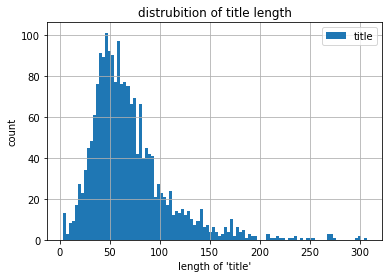

In [22]:
ax = df_askwomen['title'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'title'")
ax.set_ylabel("count")
ax.set_title('distrubition of title length')

In [23]:
#checking the shortest titles
df_askwomen[df_askwomen['title'].str.len()<15]

,subreddit,title,selftext
9,AskWomen,Why victims?,[removed]
72,AskWomen,Who can help??,[removed]
74,AskWomen,what is this,[removed]
117,AskWomen,what do i do?,[removed]
209,AskWomen,Which one,[removed]
252,AskWomen,why?,[removed]
253,AskWomen,why,[removed]
263,AskWomen,tell me why,[removed]
384,AskWomen,who's next?,[removed]
407,AskWomen,What is a man?,[removed]


In [24]:
print("Those shortest titles do not show many meaningful or complete topics. But we will decide what to do after EDA the title of 'AskMen'")

Those shortest titles do not show many meaningful or complete topics. But we will decide what to do after EDA the title of 'AskMen'


### EDA : 'selftext'


Text(0.5, 1.0, 'distrubition of selftext length')

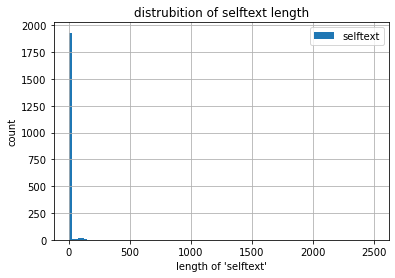

In [25]:
ax = df_askwomen['selftext'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'selftext'")
ax.set_ylabel("count")
ax.set_title('distrubition of selftext length')

In [26]:
print("Most selftext have same length")

Most selftext have same length


In [101]:
df_askwomen[df_askwomen['selftext'].str.len()<15].head(15)

,subreddit,title,selftext,title + selftext
0,AskWomen,How often do you masturbate?,[],How often do you masturbate?[]
1,AskWomen,How would you hear “No one could ever be as at...,[],How would you hear “No one could ever be as at...
2,AskWomen,“No one could ever be as attracted to you as I...,[],“No one could ever be as attracted to you as I...
3,AskWomen,What is your experience of staying with a miso...,[],What is your experience of staying with a miso...
4,AskWomen,Why is it more socially acceptable when a woma...,[],Why is it more socially acceptable when a woma...
6,AskWomen,Why does your summer suck so far?,[],Why does your summer suck so far?[]
7,AskWomen,Why are relatively older men who date younger ...,[],Why are relatively older men who date younger ...
8,AskWomen,Why are women dating relatively older men seen...,[],Why are women dating relatively older men seen...
9,AskWomen,Why victims?,[],Why victims?[]
10,AskWomen,Why victims of predators.,[],Why victims of predators.[]


In [28]:
print("most self text are '[removed]', which may indicate author didn't write anything or deleted. We will replace them with string ''")

most self text are '[removed]', which may indicate author didn't write anything or deleted. We will replace them with string ''


In [29]:
#replace '[removed]' with ''
df_askwomen['selftext'].replace('[removed]','', inplace=True, regex=True)

In [30]:
df_askwomen[df_askwomen['selftext'].str.contains('[removed]')].count()

subreddit    0
title        0
selftext     0
dtype: int64

#### This project is to classify which subreddit a given post came from， we will do so by NLP the 'title' and 'selftext'.  For convenience, we will combine these two columns into a new column called 'title + selftext'

### create new column 'title + selftext'

In [31]:
df_askwomen['title + selftext'] = df_askwomen['title'] + df_askwomen['selftext']
df_askwomen.head()

,subreddit,title,selftext,title + selftext
0,AskWomen,How often do you masturbate?,[],How often do you masturbate?[]
1,AskWomen,How would you hear “No one could ever be as at...,[],How would you hear “No one could ever be as at...
2,AskWomen,“No one could ever be as attracted to you as I...,[],“No one could ever be as attracted to you as I...
3,AskWomen,What is your experience of staying with a miso...,[],What is your experience of staying with a miso...
4,AskWomen,Why is it more socially acceptable when a woma...,[],Why is it more socially acceptable when a woma...


## NLP 'title + selftext'
**We have created 3 tokenizers as belows:**
- ragex_tokenize: tokenize corpus using regex rule r'(?u)\b\w\w+\b')
- lem_tokenize: apply regex_tokenize to the corpus first and then lemmatize the tokens
- stem_tokenize: apply regex_tokenize to the corpus first and then stem the tokens

**We will apply the 3 tokenizers on df_askwomen['title + selftext'] and df_askmen['title + selftext'] separately, and we will explore the results by plotting the most frequent words** 

#### plot most frequent words of df_askwomen['title + selftext'] after tokenization by regex_tokenize:

ploting most frequent words of df_askwomen['title + selftext'] after tokenization by regex_tokenize


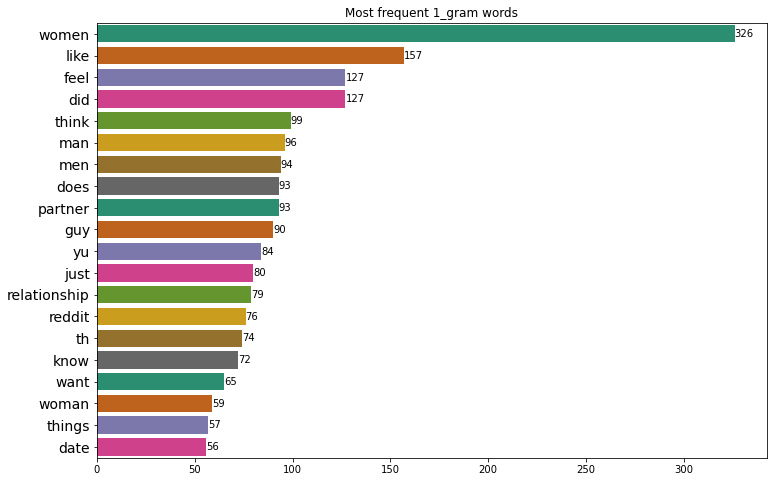

In [32]:
print("ploting most frequent words of df_askwomen['title + selftext'] after tokenization by regex_tokenize")
corpus=df_askwomen['title + selftext']
plot_top_ngram(corpus,
               tokenizer_ = regex_tokenize,
               n_gram=1,  
               top_n=20   # how many words to return
              );
    

#### plot most frequent words of df_askwomen['title + selftext'] after tokenization by lem_tokenize:

ploting most frequent words of df_askwomen['title + selftext'] after tokenization by lem_tokenize


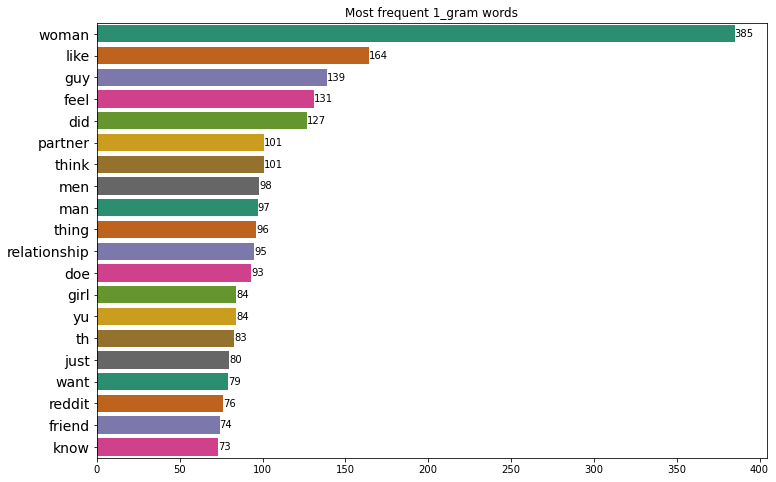

In [33]:
print("ploting most frequent words of df_askwomen['title + selftext'] after tokenization by lem_tokenize")
corpus=df_askwomen['title + selftext']
plot_top_ngram(corpus,
               tokenizer_ = lem_tokenize,
               n_gram=1,  
                top_n=20   # how many words to return
              );
    

#### plot most frequent words of df_askwomen['title + selftext'] after tokenization by stem_tokenize:¶

ploting most frequent words of df_askwomen['title + selftext'] after tokenization by stem_tokenize


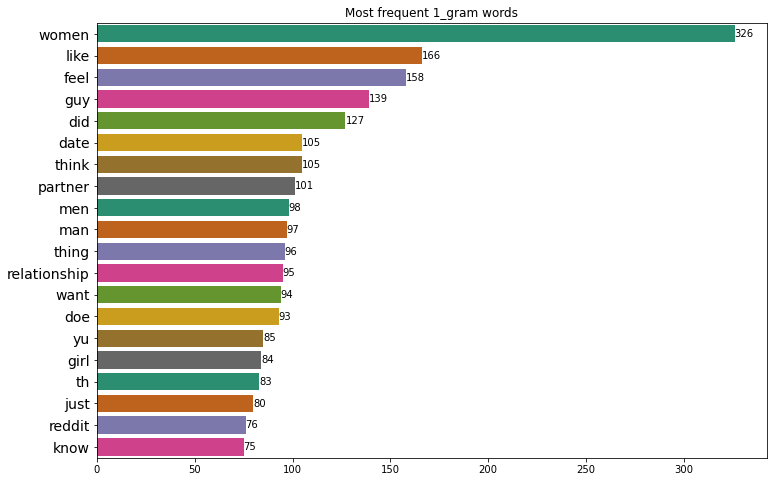

In [34]:
print("ploting most frequent words of df_askwomen['title + selftext'] after tokenization by stem_tokenize")
corpus=df_askwomen['title + selftext']
plot_top_ngram(corpus,
               tokenizer_ = stem_tokenize,
               n_gram=1,  
                top_n=20   # how many words to return
              );

**Observations:**
- The most frequent words are almost same with and without lemmatizer or stemmer. It may indicate that these 3 tokenizers will not impact the model perfermance in a large scale. But we will still add these 3 tokenizers into hypermeter list in order to build a best model 

## Data cleaning and EDA : df_askmen

In [35]:
df_askmen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  2000 non-null   object
 1   title      2000 non-null   object
 2   selftext   1979 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


In [36]:
#convert 'selftext' and 'title' to string type
df_askmen['title']=df_askmen['title'].astype("str")
df_askmen['selftext']=df_askmen['selftext'].astype("str")

### handle null values

In [37]:
(df_askmen.isnull().sum()/len(df_askmen)*100).sort_values(ascending=False)

subreddit   0.00
title       0.00
selftext    0.00
dtype: float64

In [38]:
print("No null values found")

No null values found


## EDA: 'title'

Text(0.5, 1.0, 'Distribution of title length')

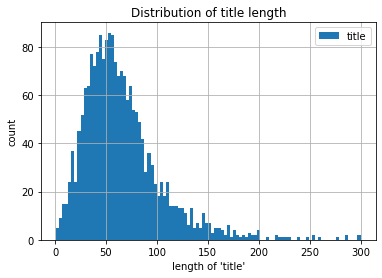

In [39]:
ax = df_askmen['title'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'title'")
ax.set_ylabel("count")
ax.set_title('Distribution of title length')

In [102]:
#print out the shortest titles
df_askmen[df_askmen['title'].str.len()<10].head(15)

,subreddit,title,selftext,title + selftext
101,AskMen,Help,[],Help[]
113,AskMen,Help me.,[],Help me.[]
137,AskMen,Cooking,[],Cooking[]
186,AskMen,Why???,[],Why???[]
241,AskMen,Venting,[],Venting[]
468,AskMen,wha,[],wha[]
473,AskMen,DM,[],DM[]
474,AskMen,s,[],s[]
515,AskMen,Nsfw,[],Nsfw[]
540,AskMen,help pls,[],help pls[]


In [41]:
print('the shortest titles in "AskMen" are quite different from those in "AskWomen", \
whose words might be good features to classify these two subreddits. We will not delete any of them first')


the shortest titles in "AskMen" are quite different from those in "AskWomen", whose words might be good features to classify these two subreddits. We will not delete any of them first


#### EDA : 'selftext'


Text(0.5, 1.0, "distribution of 'selftext' length")

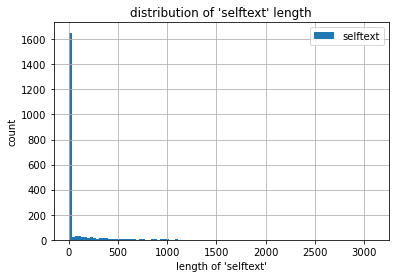

In [42]:
ax = df_askmen['selftext'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'selftext'")
ax.set_ylabel("count")
ax.set_title("distribution of 'selftext' length")

In [43]:
df_askmen[df_askmen['selftext'].str.len()<15]

,subreddit,title,selftext
0,AskMen,Is wearing a wig a turn off,[removed]
1,AskMen,Do men come up to MOST women to ask for relati...,[removed]
2,AskMen,You have a 16 year old daughter who generally ...,
3,AskMen,mods are vir....,[removed]
4,AskMen,Do you have a specific hair routine and what k...,[removed]
5,AskMen,Childfree men do you like your lifestyle?,[removed]
6,AskMen,"Men, is post nut clarity real ?",[removed]
7,AskMen,Why is it more socially acceptable when a woma...,
9,AskMen,Do women in US have lower standard of living t...,[removed]
11,AskMen,Check out michelle francis's video! #TikTok,[removed]


In [44]:
print("most self text are '[removed]', which may indicate author didn't write anything or deleted the content. We will replace them with string ''")

most self text are '[removed]', which may indicate author didn't write anything or deleted the content. We will replace them with string ''


In [45]:
df_askmen['selftext'].replace('[removed]','', inplace=True, regex=True)


In [46]:
df_askmen[df_askmen['selftext'].str.contains('[removed]')].count()

subreddit    0
title        0
selftext     0
dtype: int64

#### This project is to classify which subreddit a given post came from， we will do so by NLP the 'title' and 'selftext'.  For convenience, we will combine these two columns into a new column called 'title + selftext'

### create new column 'title + selftext'

In [47]:
df_askmen['title + selftext'] = df_askmen['title'] + df_askmen['selftext']
df_askmen.head()

,subreddit,title,selftext,title + selftext
0,AskMen,Is wearing a wig a turn off,[],Is wearing a wig a turn off[]
1,AskMen,Do men come up to MOST women to ask for relati...,[],Do men come up to MOST women to ask for relati...
2,AskMen,You have a 16 year old daughter who generally ...,,You have a 16 year old daughter who generally ...
3,AskMen,mods are vir....,[],mods are vir....[]
4,AskMen,Do you have a specific hair routine and what k...,[],Do you have a specific hair routine and what k...


### NLP 'title + selftext'
**We have created 3 tokenizers as belows:**
- ragex_tokenize: tokenize corpus using regex rule r'(?u)\b\w\w+\b')
- lem_tokenize: apply regex_tokenize to the corpus first and then lemmatize the tokens
- stem_tokenize: apply regex_tokenize to the corpus first and then stem the tokens

**We will apply the 3 tokenizers on df_askwomen['title + selftext'] and df_askmen['title + selftext'] separately, and we will explore the results by plotting the most frequent words** 

#### plot most frequent words of df_askmen['title + selftext'] after tokenization by regex_tokenize:
- All plots have excluded stopwords, but stopwords are included in hypermeter list of GridSearchCV for tuning

ploting most frequent words of df_askmen['title + selftext'] after tokenization by regex_tokenize


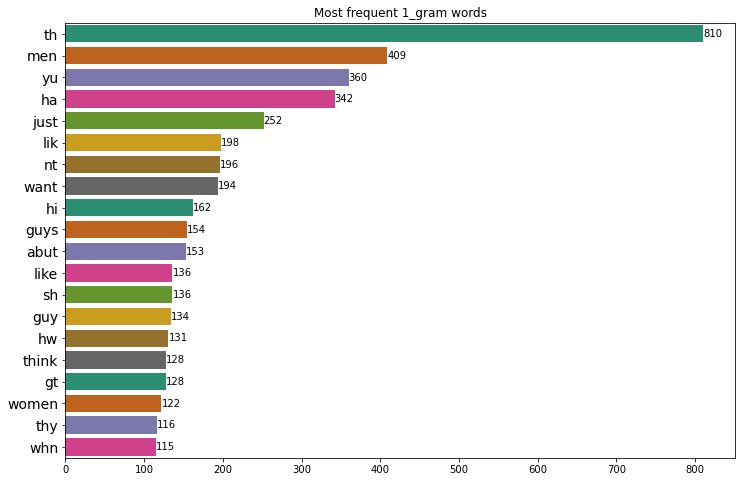

In [48]:
print("ploting most frequent words of df_askmen['title + selftext'] after tokenization by regex_tokenize")
corpus=df_askmen['title + selftext']
plot_top_ngram(corpus,
               tokenizer_ = regex_tokenize,
               n_gram=1,  
               top_n=20   # how many words to return
              );
    

#### plot most frequent words of df_askmen['title + selftext'] after tokenization by lem_tokenize:

ploting most frequent words of df_askmen['title + selftext'] after tokenization by lem_tokenize


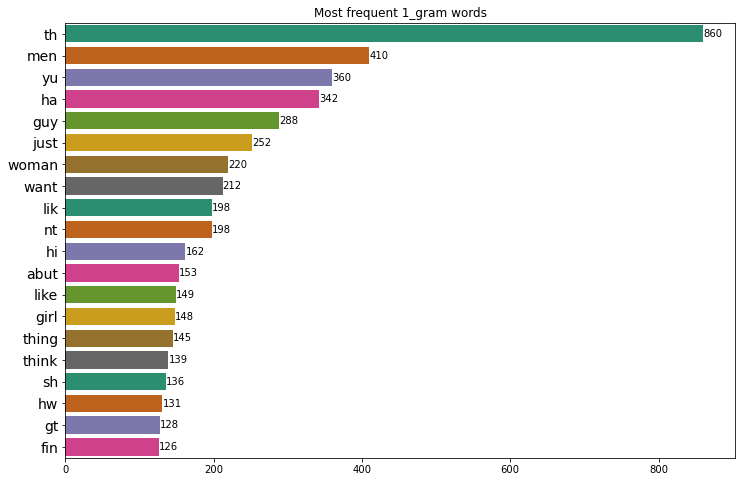

In [49]:
print("ploting most frequent words of df_askmen['title + selftext'] after tokenization by lem_tokenize")
corpus=df_askmen['title + selftext']
plot_top_ngram(corpus,
               tokenizer_ = lem_tokenize,
               n_gram=1,  
                top_n=20   # how many words to return
              );
    

#### plot most frequent words of df_askmen['title + selftext'] after tokenization by stem_tokenize:

ploting most frequent words of df_askmen['title + selftext'] after tokenization by stem_tokenize


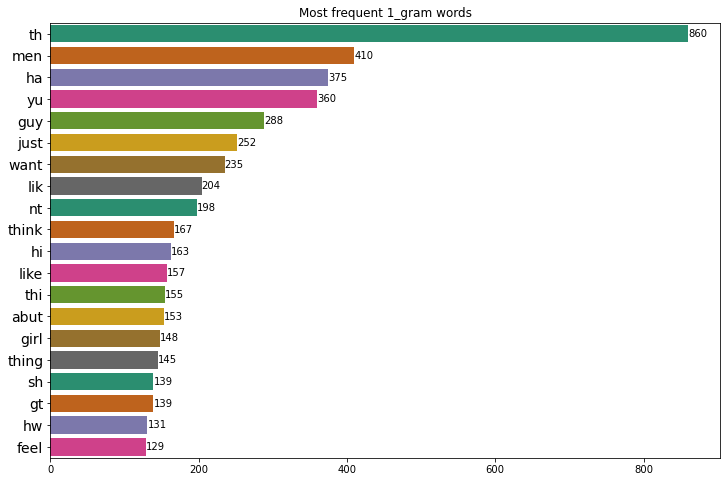

In [50]:
print("ploting most frequent words of df_askmen['title + selftext'] after tokenization by stem_tokenize")
corpus=df_askmen['title + selftext']
plot_top_ngram(corpus,
               tokenizer_ = stem_tokenize,
               n_gram=1,  
                top_n=20   # how many words to return
              );

**Observations:**
- The most frequent words are almost same with and without lemmatizer or stemmer. It may indicate that these 3 tokenizers will not impact the model perfermance in a large scale. We will still try them in hypermeter tuning

### compare  most frequent n_gram words of df_askwomen['title + selftext'] and df_askmen['title + selftext']

**plot 1_gram most frequent words**

plot most frequent 1_gram words of AskWomen 


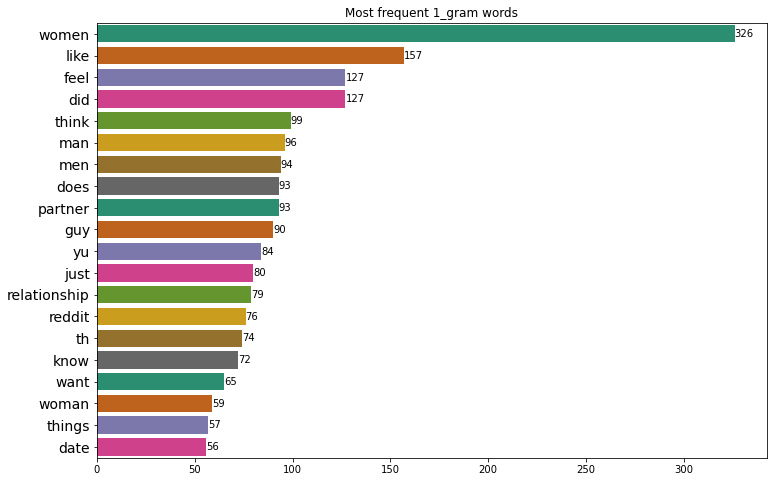

In [51]:
print('plot most frequent 1_gram words of AskWomen ')
corpus=df_askwomen['title + selftext']
plot_top_ngram(corpus, n_gram=1, top_n=20);

plot most frequent 1_gram words of Askmen 


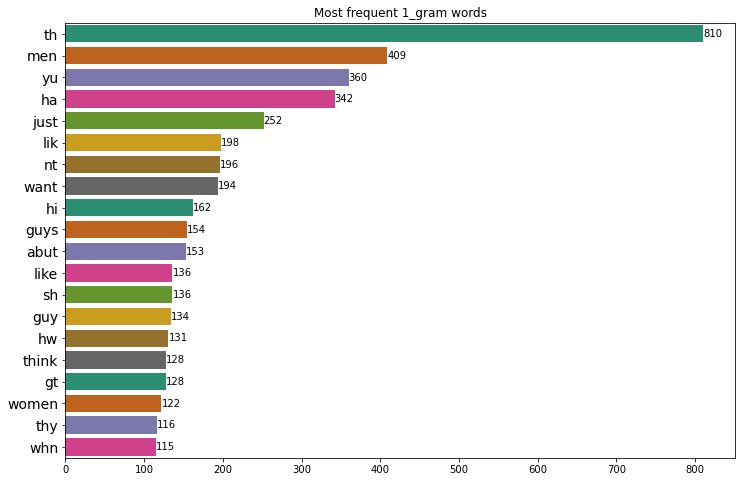

In [52]:
print('plot most frequent 1_gram words of Askmen ')
corpus=df_askmen['title + selftext']
plot_top_ngram(corpus, n_gram=1, top_n=20);


**Observations:**
- The most frequent 1_gram words of these two subreddits are quite different. 
- Many abbreviations appear in the askmen's list, which seems to be good indicators for our models

**plot 2_gram**

plot most frequent 2_gram words of AskWomen 


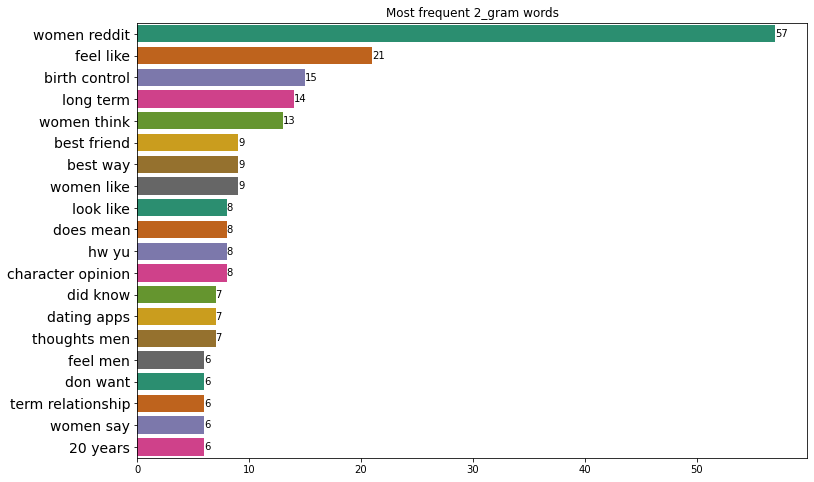

In [53]:
print('plot most frequent 2_gram words of AskWomen ')
corpus=df_askwomen['title + selftext']
plot_top_ngram(corpus, n_gram=2, top_n=20);

plot most frequent 2_gram words of Askmen 


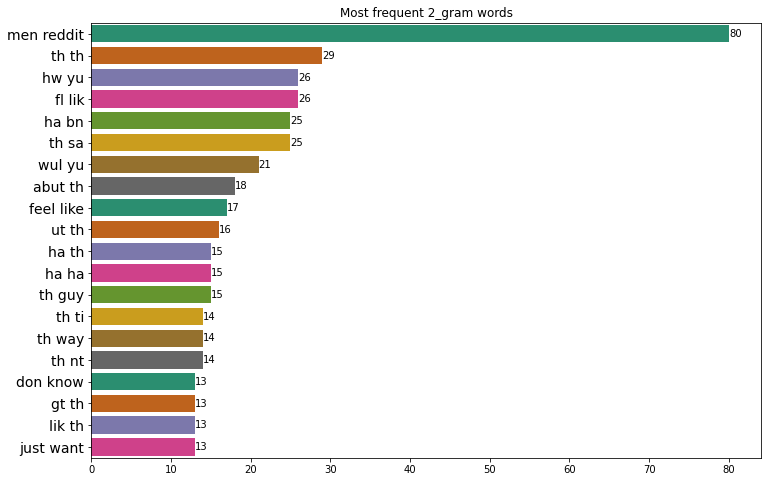

In [54]:
print('plot most frequent 2_gram words of Askmen ')
corpus=df_askmen['title + selftext']
plot_top_ngram(corpus, n_gram=2, top_n=20);


**Observations:**
- The most frequent 2_gram words of these two subreddits are quite different. 
- Many abbreviations appear in the askmen's list

**plot 3_gram**

plot most frequent 3_gram words of AskWomen 


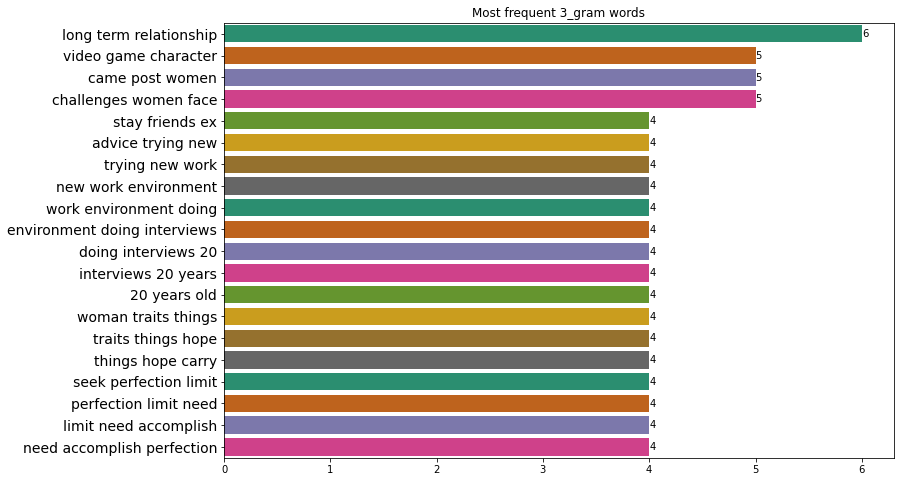

In [55]:
print('plot most frequent 3_gram words of AskWomen ')
corpus=df_askwomen['title + selftext']
plot_top_ngram(corpus, n_gram=3, top_n=20);

plot most frequent 3_gram words of Askmen 


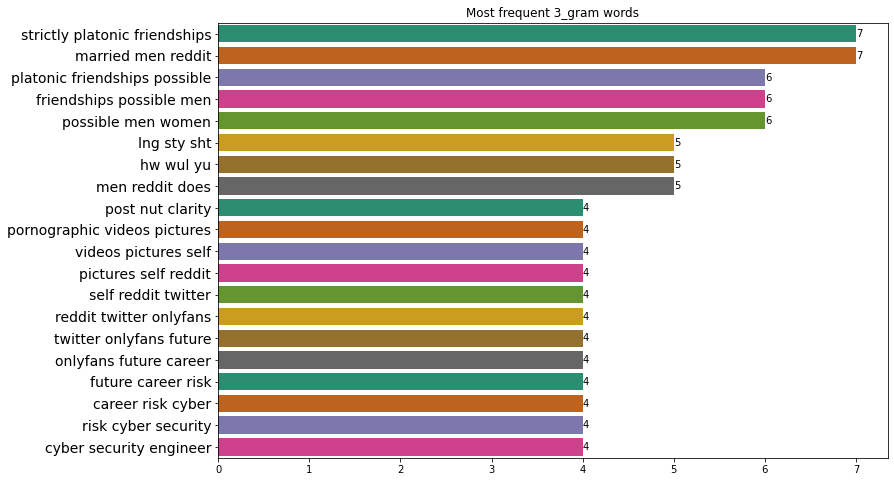

In [56]:
print('plot most frequent 3_gram words of Askmen ')
corpus=df_askmen['title + selftext']
plot_top_ngram(corpus, n_gram=3, top_n=20);


**Observations:**
- The most frequent 3_gram words of these two subreddits are completely different. 
- 3_gram words seem to be good features for classification but we need to beware of generalization issues

### plot word cloud of most frequent words from AskWomen and Askmen


ploting the word cloud of df_askwomen["title + selftext"]


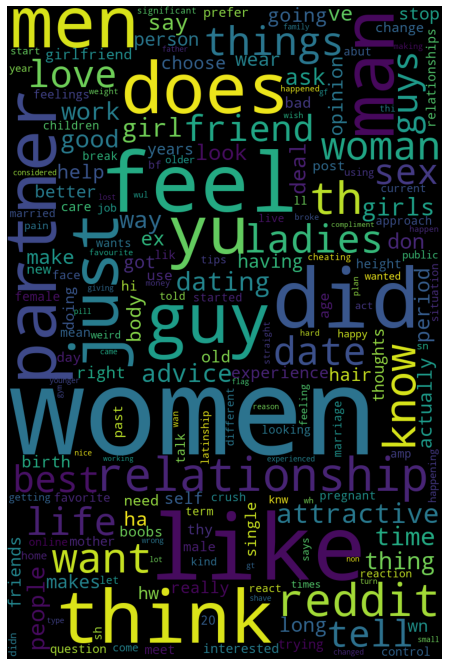

In [57]:
#plot word cloud of askWomen
print('ploting the word cloud of df_askwomen["title + selftext"]')
plot_wordcloud(df_askwomen['title + selftext'],
              tokenizer_ = None, #default tokenizer
               n_gram=1)

ploting the word cloud of df_askmen["title + selftext"]


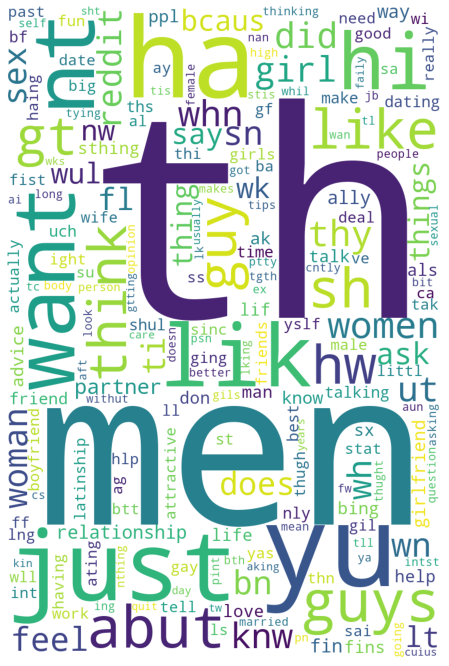

In [58]:
#plot word cloud of askmen
print('ploting the word cloud of df_askmen["title + selftext"]')
plot_wordcloud(df_askmen['title + selftext'],
              tokenizer_ = None, #default tokenizer
              n_gram=1, 
              bg_color='white')

In [59]:
print("Abbreviations occur more frequently in 'AskMen' than 'AskWomen'")
print("Many abbreviations are stopwords")

Abbreviations occur more frequently in 'AskMen' than 'AskWomen'
Many abbreviations are stopwords


### Concatenate two dataframes and convert subreddits into binary labels:

In [60]:
#concatenate two dataframes
df = pd.concat(objs=[df_askwomen,df_askmen], axis=0) 
df = df.reset_index(drop=True)

In [61]:
#covert subreddits into binary labels
df['subreddit'] = df['subreddit'].map({'AskWomen' : 0, 'AskMen' : 1})
df.head()

,subreddit,title,selftext,title + selftext
0,0,How often do you masturbate?,[],How often do you masturbate?[]
1,0,How would you hear “No one could ever be as at...,[],How would you hear “No one could ever be as at...
2,0,“No one could ever be as attracted to you as I...,[],“No one could ever be as attracted to you as I...
3,0,What is your experience of staying with a miso...,[],What is your experience of staying with a miso...
4,0,Why is it more socially acceptable when a woma...,[],Why is it more socially acceptable when a woma...


In [62]:
X = df['title + selftext']
y = df['subreddit']

In [63]:
# Check what we need to check in a classification problem.
y.value_counts(normalize = True)

1   0.50
0   0.50
Name: subreddit, dtype: float64

In [64]:
print('The dataset does not have imbalance issues')

The dataset does not have imbalance issues


## Modeling

### 1. Metrics
- To use **ROC AUC** to compare model perforamce, because the **AUC metric** utilizes probabilities of class prediction. Based on that, we’re able to more precisely evaluate and compare the models.
    - The closer to 1, the better 'ROC AUC' is
    - perc_diff must be less than 5%
- To compare **Accuracy score** too. Since our data is balance and both positive and negative results are of same importance to us, **Accuracy score** is another good metric which is understandable and intuitive even to a non-technical person
    - The closer to 1, the better 'Accuracy' is
    - perc_diff must be less than 5%

### 2. Do Train-Test Split

In [65]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=4222)

### 3. Baseline Score

In [66]:
y_train.value_counts(normalize=True)

1   0.50
0   0.50
Name: subreddit, dtype: float64

In [67]:
print('The expected chance to guess correctly a post from "AskMen" or "AskWomen" is 50% ')
print('The accuracy score is 0.5')

The expected chance to guess correctly a post from "AskMen" or "AskWomen" is 50% 
The accuracy score is 0.5


### 4. Model: TfidfVectorizer + RandomForest

best_params: 
    classifier__max_depth  :  6
    classifier__n_estimators  :  500
    tvec__max_features  :  350
    tvec__ngram_range  :  (1, 3)
    tvec__stop_words  :  None
    tvec__tokenizer  :  None

roc_auc_score on training set: 0.860
roc_auc_score on testing set: 0.824
perc_diff: 4.1 %


accuracy_score on training set: 0.767
accuracy_score on testing set: 0.770
perc_diff: 0.3 %

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            582           78
actual AskMen              226          434

plot confusion matrix and ROC curve


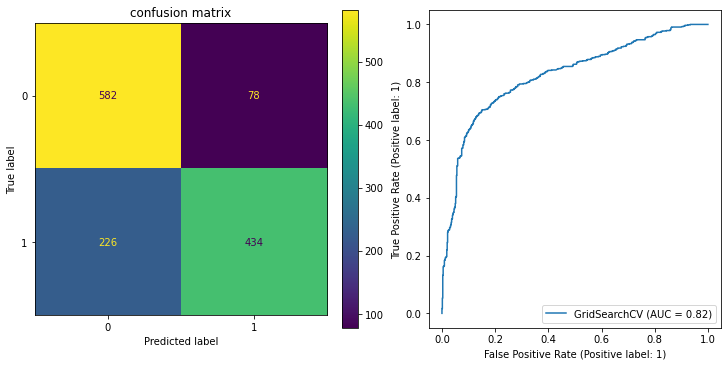

Wall time: 3min 36s


In [99]:
%%time
# Set up a pipeline with tf-idf vectorizer and RandomForestClassifier
pipe_tvec_rf = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier',RandomForestClassifier(random_state=42))
                    ])



#pipeline parameters
pipe_tvec_rf_params = {
                    #params of TfidfVectorizer
                    'tvec__tokenizer' : [None,stem_tokenize,lem_tokenize],# tokenizer: default tokenizer, stem_tokenize,lem_tokenize
                    'tvec__max_features': [350,400,500],              # Maximum number of features fit:350,400,500
                    'tvec__stop_words': [None, 'english'],            # No stop words and english stop words
                    'tvec__ngram_range': [(1,1), (1,2),(1,3)],        # n_gram range: (1,1), (1,2), (1,3)
    
                    #params of random forest
                    'classifier__n_estimators' : [300,500],       #The number of trees in the forest.
                    'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
                    }


# Instantiate GridSearchCV.
gs_tvec_rf = GridSearchCV(pipe_tvec_rf, # what object are we optimizing?
                        param_grid = pipe_tvec_rf_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )
#finding the best hypermeter list for the model
run_model(gs_tvec_rf, X_train, y_train, X_test, y_test )

In [69]:
print('The model has roc_auc_score of 0.824 on testing set, and the perc_diff is 4.1%, less than 5% ')
print('The model passed metrics and become one candidate to be final model')

The model has roc_auc_score of 0.824 on testing set, and the perc_diff is 4.1%, less than 5% 
The model passed metrics and become one candidate to be final model


In [70]:
print('The expected chance to predict a post from "AskMen" or "AskWomen" correctly by this model is 77% ')
print('The accuracy score is 0.77')

The expected chance to predict a post from "AskMen" or "AskWomen" correctly by this model is 77% 
The accuracy score is 0.77


**Observations from best_params:**
- Only use 350 features
- Better result without removal of stopwords
- Better result without lemmatizing or stemming




### 5. Model: TfidfVectorizer + LogisticRegression

best_params: 
    classifier__C  :  1
    classifier__penalty  :  l1
    tvec__max_features  :  1000
    tvec__ngram_range  :  (1, 3)
    tvec__stop_words  :  None
    tvec__tokenizer  :  None

roc_auc_score on training set: 0.859
roc_auc_score on testing set: 0.851
perc_diff: 0.9 %


accuracy_score on training set: 0.785
accuracy_score on testing set: 0.790
perc_diff: 0.7 %

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            543          117
actual AskMen              160          500

plot confusion matrix and ROC curve


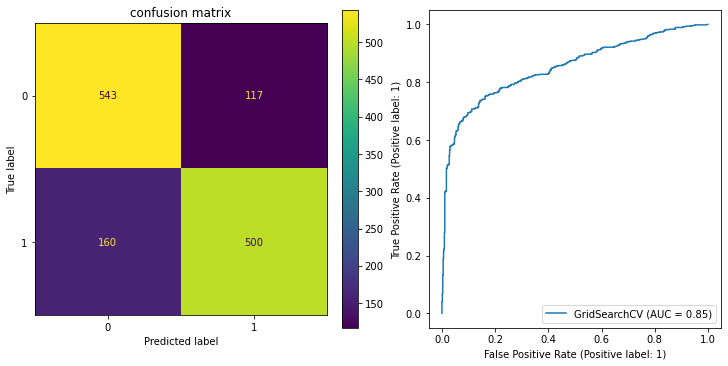

Wall time: 44.4 s


In [98]:
%%time

# Set up a pipeline with tf-idf vectorizer and LogisticRegression
pipe_tvec_lr = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', LogisticRegression(solver='liblinear'))
                    ])


#pipeline parameters
pipe_tvec_lr_params = {
                     #params of TfidfVectorizer
                    'tvec__tokenizer' : [None,stem_tokenize,lem_tokenize], # tokenizer: default tokenizer, stem_tokenize,lem_tokenize
                    'tvec__max_features': [ 900,1_000, 1_100],          # Maximum number of features fit
                    'tvec__stop_words': [None, 'english'],                  # No stop words and english stop words
                    'tvec__ngram_range': [(1,1), (1,2),(1,3)],              # n_gram range: (1,1), (1,2), (1,3)
    
    
                     #params of bagging naive bayes
                    'classifier__C' :  [10**-1, 10**0],      #Inverse of regularization strength
                    'classifier__penalty'  : ['l1','l2'],           #Specify the norm of the penalty:
    
                    }


# Instantiate GridSearchCV.
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, # what object are we optimizing?
                        param_grid = pipe_tvec_lr_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

#searching the best hypermeter list for the model
run_model(gs_tvec_lr, X_train, y_train, X_test, y_test )

In [72]:
print('The model has roc_auc_score of 0.851 on testing set, and the perc_diff is 0.9%, less than 5% ')
print('The model passed metrics and become one candidate to be final model')

The model has roc_auc_score of 0.851 on testing set, and the perc_diff is 0.9%, less than 5% 
The model passed metrics and become one candidate to be final model


In [73]:
print('The expected chance to predict a post from "AskMen" or "AskWomen" correctly by this model is 79% ')
print('The accuracy score is 0.79')

The expected chance to predict a post from "AskMen" or "AskWomen" correctly by this model is 79% 
The accuracy score is 0.79


**Observations from best_params:**
- Better result without removal of stopwords
- Better result without lemmatizing or stemming



### 6. Model performance comparison

**Comparing ROC AUC**

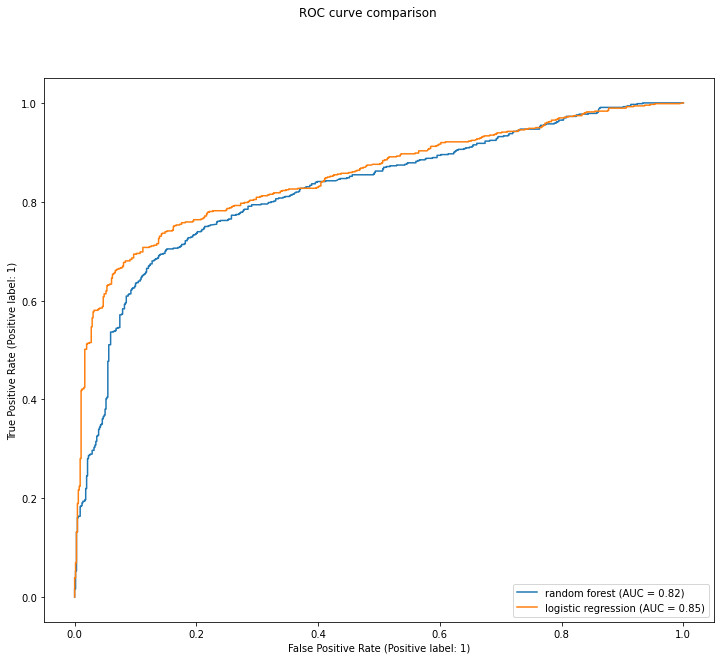

In [74]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
#plot ROC curve
fig=RocCurveDisplay.from_estimator(gs_tvec_rf, X_test, y_test,name="random forest") 
RocCurveDisplay.from_estimator(gs_tvec_lr, X_test, y_test, name='logistic regression',ax = fig.ax_) 
fig.figure_.suptitle("ROC curve comparison")
plt.show()

**Observations:**
- Logistic Regression Model outperforms Random Forest Model in almost all thresholds
- We will select Logistic Regression as final model

### Feature Importance Analysis for Logistic Regression Model 

In [75]:
# get the model 
best_tvec = gs_tvec_lr.best_estimator_.named_steps['tvec']
best_lr = gs_tvec_lr.best_estimator_.named_steps['classifier']

In [76]:
# get the feature list
feature_list=best_tvec.get_feature_names_out()
print(feature_list)

['10' '20' '20s' '30' '30s' 'about' 'about being' 'about your' 'abut'
 'abut it' 'ach' 'ach th' 'across' 'act' 'actually' 'advice' 'advice for'
 'advice would' 'advice would you' 'aft' 'after' 'ag' 'again' 'age' 'ai'
 'aic' 'ak' 'aking' 'aks' 'al' 'all' 'all the' 'ally' 'als' 'alst'
 'always' 'am' 'amp' 'an' 'an ha' 'an hw' 'an it' 'an sh' 'an th' 'and'
 'and how' 'and if' 'and what' 'and why' 'another' 'anth' 'any' 'anyn'
 'anyone' 'anyone else' 'anything' 'approach' 'apps' 'are' 'are some'
 'are the' 'are you' 'are your' 'are your thoughts' 'around' 'as'
 'as woman' 'ask' 'asked' 'asking' 'ass' 'at' 'at all' 'at home' 'at th'
 'at the' 'at what' 'ating' 'attntin' 'attracted' 'attracted to'
 'attractive' 'aun' 'average' 'ay' 'ayb' 'ba' 'back' 'bad' 'bcaus' 'be'
 'be more' 'because' 'become' 'bed' 'been' 'before' 'being' 'best'
 'best friend' 'best way' 'better' 'between' 'bf' 'big' 'bing' 'birth'
 'bit' 'bn' 'body' 'boobs' 'both' 'boyfriend' 'break' 'break up' 'breast'
 'bst' 'bth' 'b

In [77]:
# get the coefficients
coefs = best_lr.coef_[0]

df_coefs =  pd.DataFrame(list(zip(feature_list,coefs)))  
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

#sort the dataframe by the descending order of 'abs_coef'
df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.set_index('feature',inplace=True)

print("printing top 20 most important features")
df_coefs.iloc[:,:-1].head(20)

printing top 20 most important features


,coef
feature,
women of,-8.94
how,-8.17
what,-7.25
men of,6.62
ladies,-6.41
why,-6.29
who,-5.93
men,5.52
men who,4.96


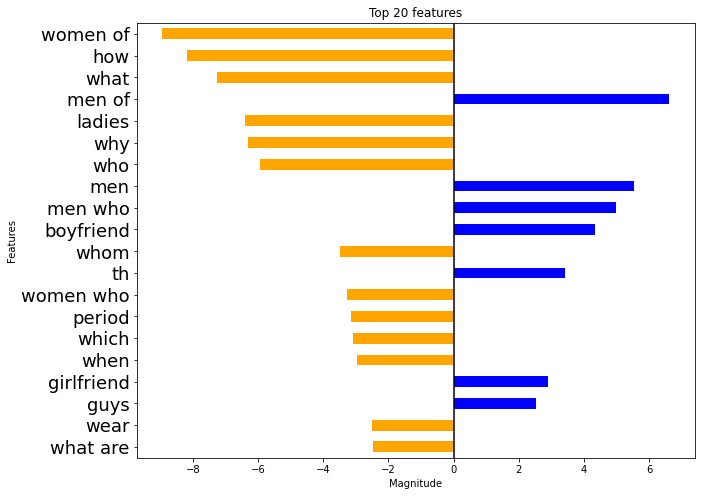

In [78]:
#plot the top features

#define bar colors
bar_colors=['blue' if coef >0 else 'orange' for coef in df_coefs['coef'] ]

plt.rcParams['figure.figsize'] = (10.0, 8.0)
ax=df_coefs.iloc[:,0].head(20).plot(kind='barh', color=bar_colors)
ax.invert_yaxis()
plt.yticks(fontsize=18, rotation=0)
plt.title('Top 20 features')
plt.xlabel('Magnitude')
plt.ylabel('Features')
plt.axvline(x=0,color='black');
plt.show()

**Observations:**
- As we set subreddit 'AskMen' as 1, all features with positive coef such as 'men of', 'men' and 'men who' are favorable to 'AskMen'
- Similarly, all features with negative coef such as 'women of', 'how' and 'what' are supporting 'AskWomen'
- 65% of top important features are favorable to 'AskWomen'
- stopwords play an important role in this model, mostly because abbreviations of stopwords such as 'whn','hw' occurs much more frequently in "AskMen". 

## Conclusions

- We fetched posts from subreddit 'AskWomen' and 'Askmen' using Pushshift Reddit API
- We performed NLP with regex tokenizer, lemmatizer,  stemmer and tfidf-vectorizer
- We built random forest model and logistic regression model. Two models had similiar performance in term of ROC AUC and Accuracy Score. But logistic regression model outperformed slightly.
- Based on logistic regression model, we analyzed the top 20 most important features and explored their contributions. We found that 65% of top important features were favorable to 'AskWomen'

## Future Enhancement
- The chosen Logistic Regression model has an accuracy score of 79%, which is not very promising. We may consider other models such SVM and AdaBoost.
- We may increase dataset size for better performance
    - We may fetch more posts, for example, from 2,000 to 4,000
    - We may fetch all related comments from each post